## Import required libraries

In [1]:
import pm4py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Import Log

There are two logs to explore. Both are filtered and projected using ProM. They include information about events, loan goal, application type and requested amount.
- event_log_full is the full log that represents the process with A_ and O_ completed events
- event_log_A contains only A_ events with traces ending with A_Pending, A_Cancelled, A_Denied. This log is used to analyse the application process outcome (successful/unsuccessful applications)

**<span style="color:red">Following paths for `event_log_full` and `event_log_A` must be changed before running</span>**

In [2]:
event_log_full = pm4py.read_xes('data/OA_events.xes')
event_log_A = pm4py.read_xes('data/end_A_event_log.xes')

/Users/xuyou/opt/anaconda3/lib/python3.9/site-packages/pm4py/util/dt_parsing/parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/31509 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/17549 [00:00<?, ?it/s]

# Distribution of End Activities

Distribution of end activities for event_log_full

In [5]:
end_activities_distribution = pm4py.get_end_activities(event_log_full)
end_activities_distribution

{'A_Pending': 12792,
 'O_Refused': 3719,
 'O_Cancelled': 14708,
 'A_Cancelled': 161,
 'A_Denied': 33,
 'A_Incomplete': 29,
 'A_Validating': 3,
 'O_Sent (online only)': 12,
 'O_Sent (mail and online)': 20,
 'A_Complete': 30,
 'O_Returned': 2}

Distribution of end activities for event_log_A

In [6]:
end_activities_distribution_A = pm4py.get_end_activities(event_log_A)
end_activities_distribution_A

{'A_Pending': 11804, 'A_Cancelled': 3382, 'A_Denied': 2363}

#### Visualisation of the Distribution for Application Outcomes

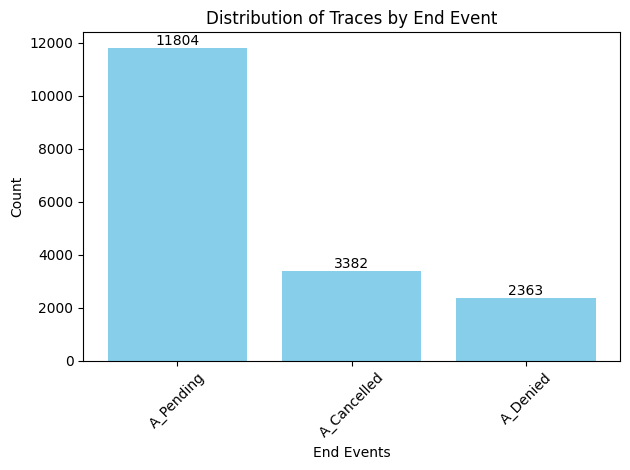

In [9]:
activities = list(end_activities_distribution_A.keys())
counts = [end_activities_distribution_A[activity] for activity in activities]

bars = plt.bar(activities, counts, color='skyblue')

plt.xlabel('End Events')
plt.ylabel('Count')
plt.title('Distribution of Traces by End Event')
plt.xticks(rotation=45)
plt.tight_layout()

# Add values on the bars
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()


#### Visualisation of the Successful and Unsuccessful Application Distribution

Concentrating exclusively on application outcomes produces three main results, categorized as either successful or unsuccessful applications. Specifically, A_Pending is considered a successful outcome for the loan application, whereas A_Denied and A_Cancelled are classified as unsuccessful outcomes. 

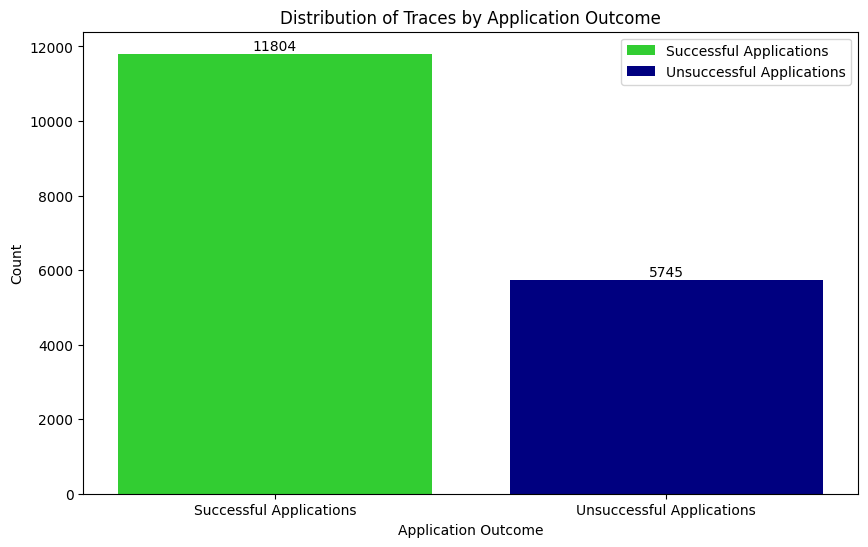

In [11]:
successful_counts = [end_activities_distribution_A.get('A_Pending', 0)]
unsuccessful_counts = [count for activity, count in end_activities_distribution_A.items() if activity != 'A_Pending']

fig, ax = plt.subplots(figsize=(10, 6))


# Bar for Successful Applications
ax.bar('Successful Applications', successful_counts, color='limegreen', label='Successful Applications')
# Bar for Unsuccessful Applications
ax.bar('Unsuccessful Applications', sum(unsuccessful_counts), color='navy', label='Unsuccessful Applications')

# Add values on the bars
for bar, count in zip(ax.patches, [successful_counts[0], sum(unsuccessful_counts)]):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, count, ha='center', va='bottom')

ax.set_xlabel('Application Outcome')
ax.set_ylabel('Count')
ax.set_title('Distribution of Traces by Application Outcome')
ax.legend()

plt.show()

# Insigths about traces

We aim to predict loan application outcomes based on events labeled O_ and A_. When forecasting results after sending the initial offers to applicants ((O_Sent (online only) and O_Sent (mail and online)), we will examine the complete event log (event_log_full).

List of all start activities

In [12]:
pm4py.get_start_activities(event_log_full)

{'A_Create Application': 31509}

Number of distinct trace variants. 

In [13]:
len(pm4py.get_variants_as_tuples(event_log_full))

2630

Transform the log into a dataframe

In [14]:
df = pm4py.convert_to_dataframe(event_log_full)
df.head(5)

,Action,EventID,EventOrigin,org:resource,concept:name,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:RequestedAmount,case:concept:name,OfferedAmount,CreditScore,Selected,MonthlyCost,Accepted,NumberOfTerms,FirstWithdrawalAmount,OfferID
0,Created,Application_652823628,Application,User_1,A_Create Application,complete,2016-01-01 10:51:15.304000+01:00,Existing loan takeover,New credit,20000.0,Application_652823628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,statechange,ApplState_1582051990,Application,User_1,A_Submitted,complete,2016-01-01 10:51:15.352000+01:00,Existing loan takeover,New credit,20000.0,Application_652823628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,statechange,ApplState_642383566,Application,User_1,A_Concept,complete,2016-01-01 10:52:36.413000+01:00,Existing loan takeover,New credit,20000.0,Application_652823628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,statechange,ApplState_99568828,Application,User_52,A_Accepted,complete,2016-01-02 12:23:04.299000+01:00,Existing loan takeover,New credit,20000.0,Application_652823628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Created,Offer_148581083,Offer,User_52,O_Create Offer,complete,2016-01-02 12:29:03.994000+01:00,Existing loan takeover,New credit,20000.0,Application_652823628,20000.0,979.0,True,498.29,True,44.0,20000.0,NaN


Print the first trace

In [15]:
from pm4py.objects.log.util.log import project_traces
def print_nth(log, index):
    print(str(project_traces(event_log_full)[index]))
    

print_nth(event_log_full, 0)

['A_Create Application', 'A_Submitted', 'A_Concept', 'A_Accepted', 'O_Create Offer', 'O_Created', 'O_Sent (mail and online)', 'A_Complete', 'A_Validating', 'O_Returned', 'A_Incomplete', 'A_Validating', 'O_Accepted', 'A_Pending']


# Process Model Visualization

#### Visualisation of DFG for the event log

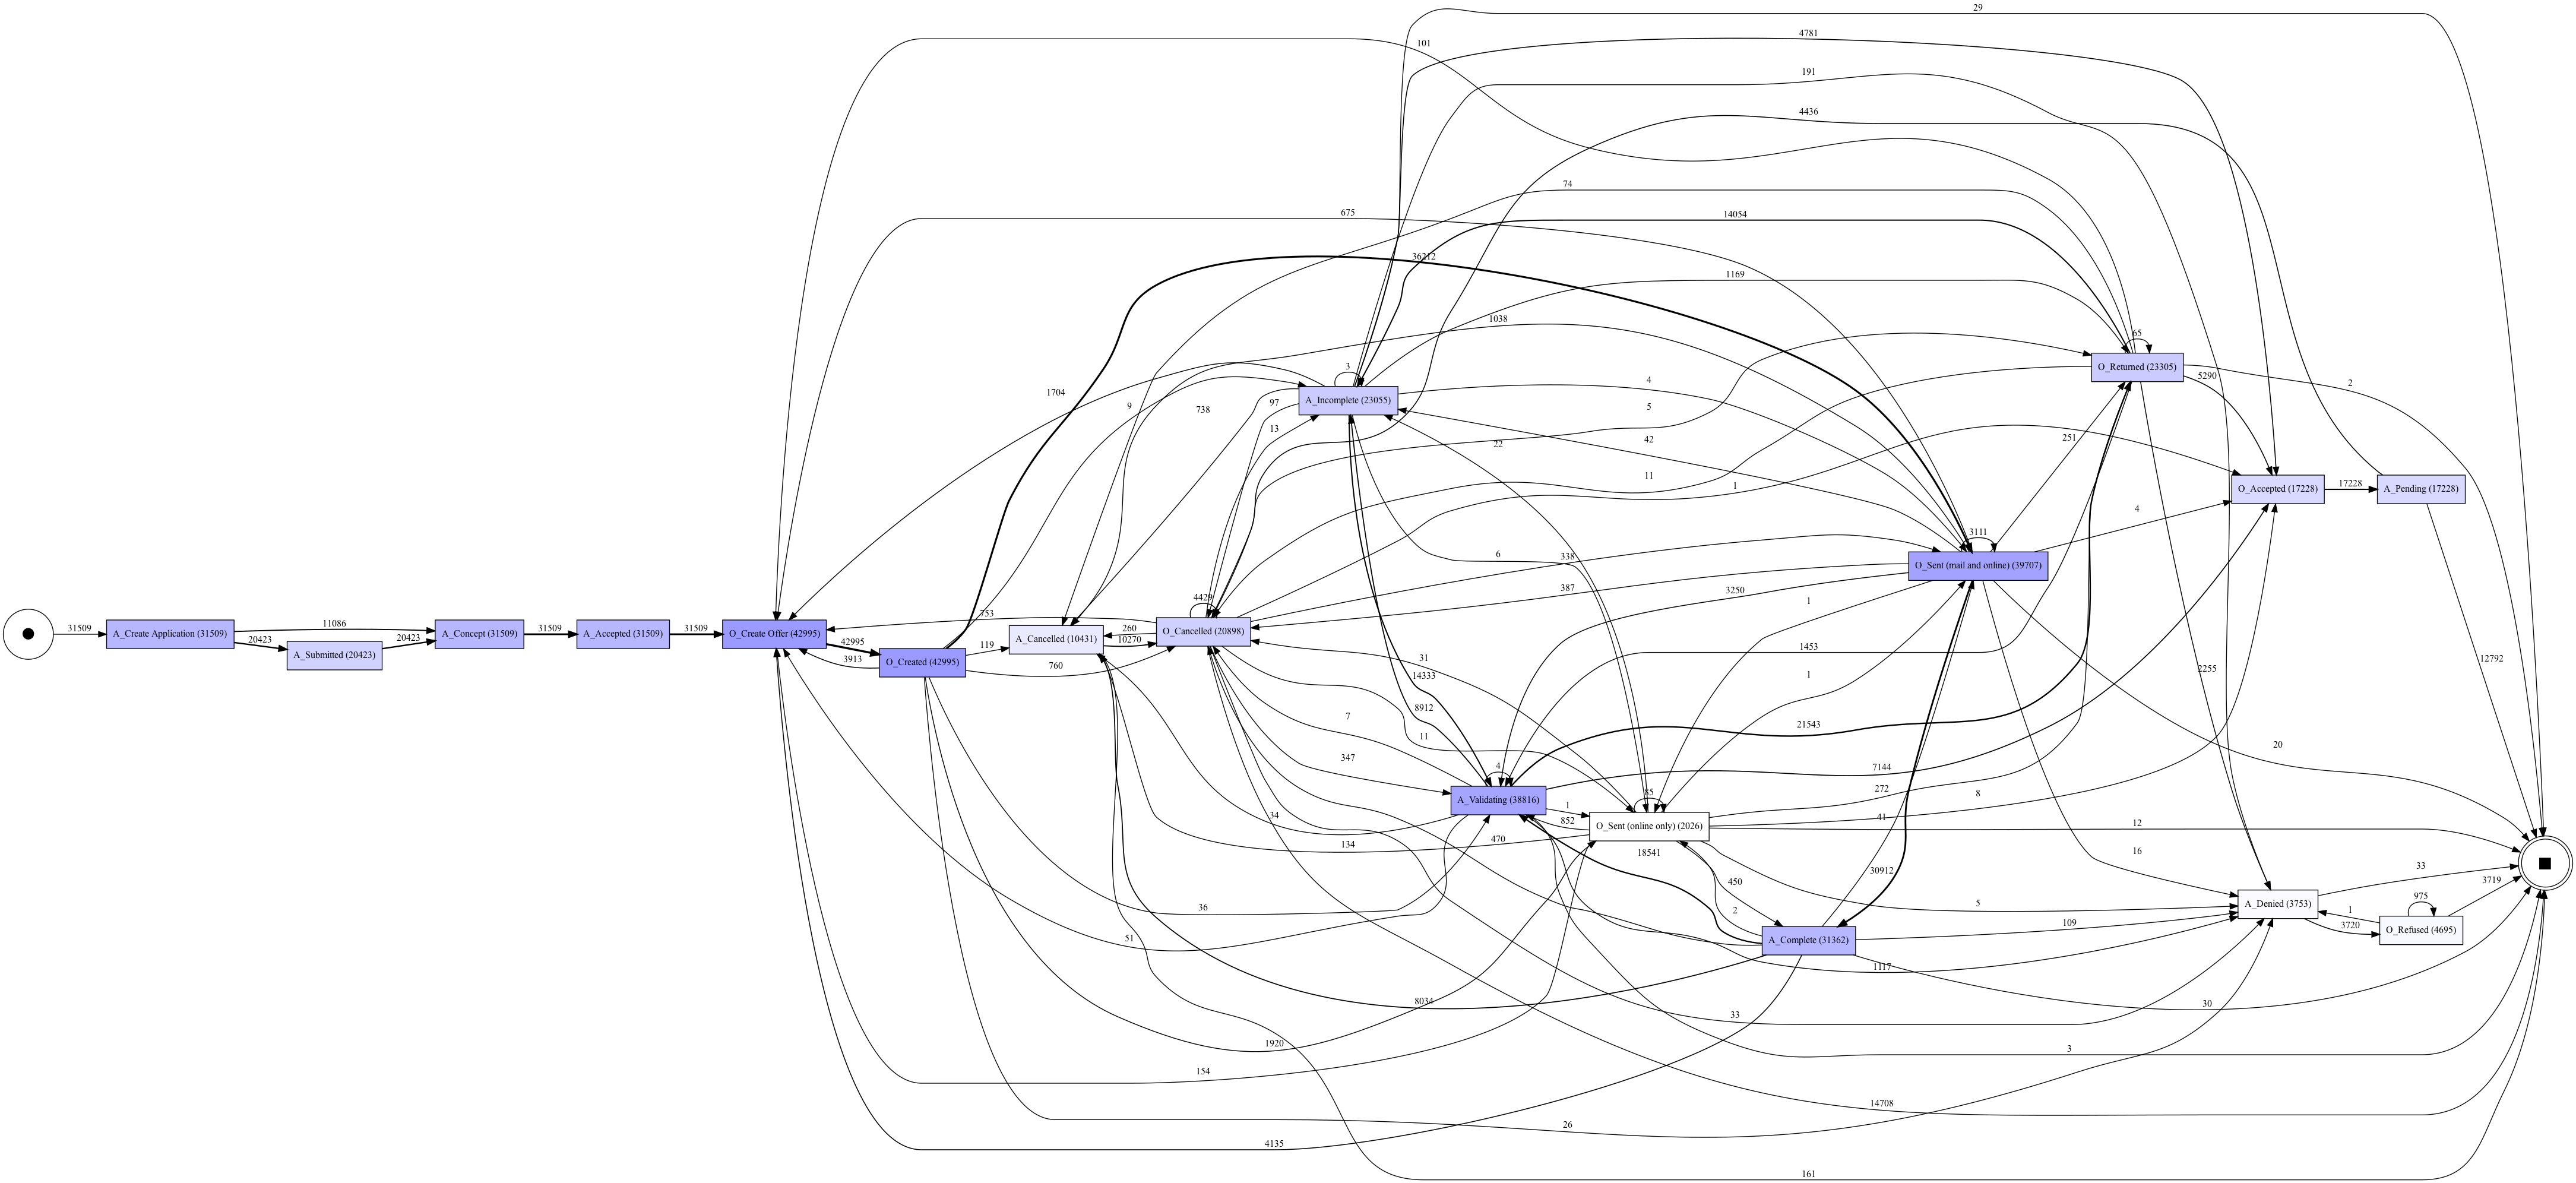

In [3]:
dfg, start_activities, end_activities = pm4py.discover_dfg(event_log_full)
pm4py.view_dfg(dfg, start_activities, end_activities)

#### Alpha miner - net (petri net)

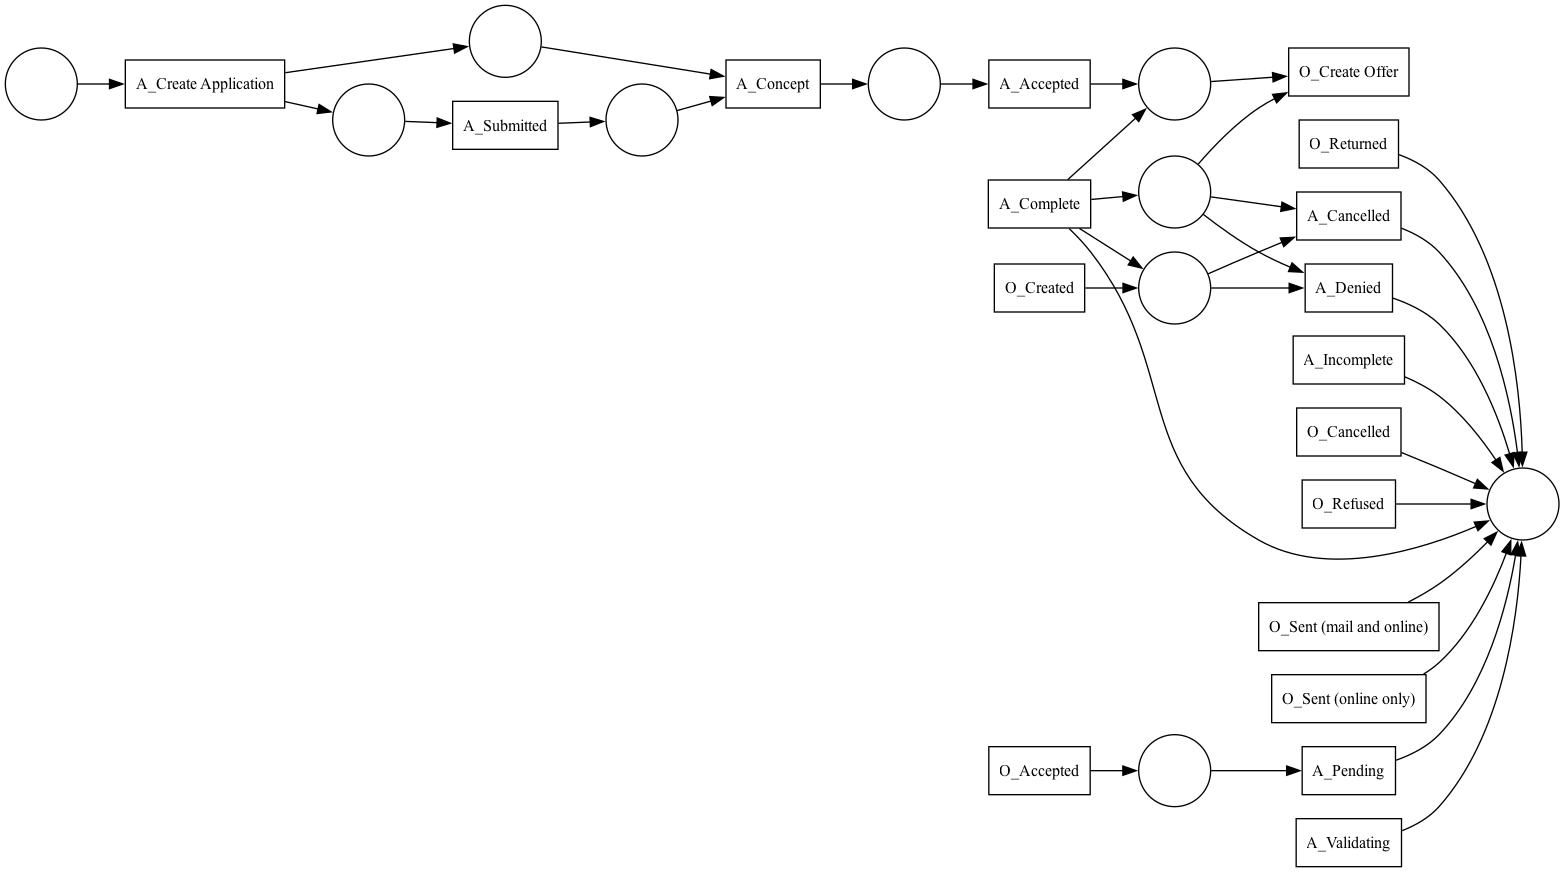

In [25]:
net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(event_log_full)
pm4py.view_petri_net(net)

#### Inductive miner

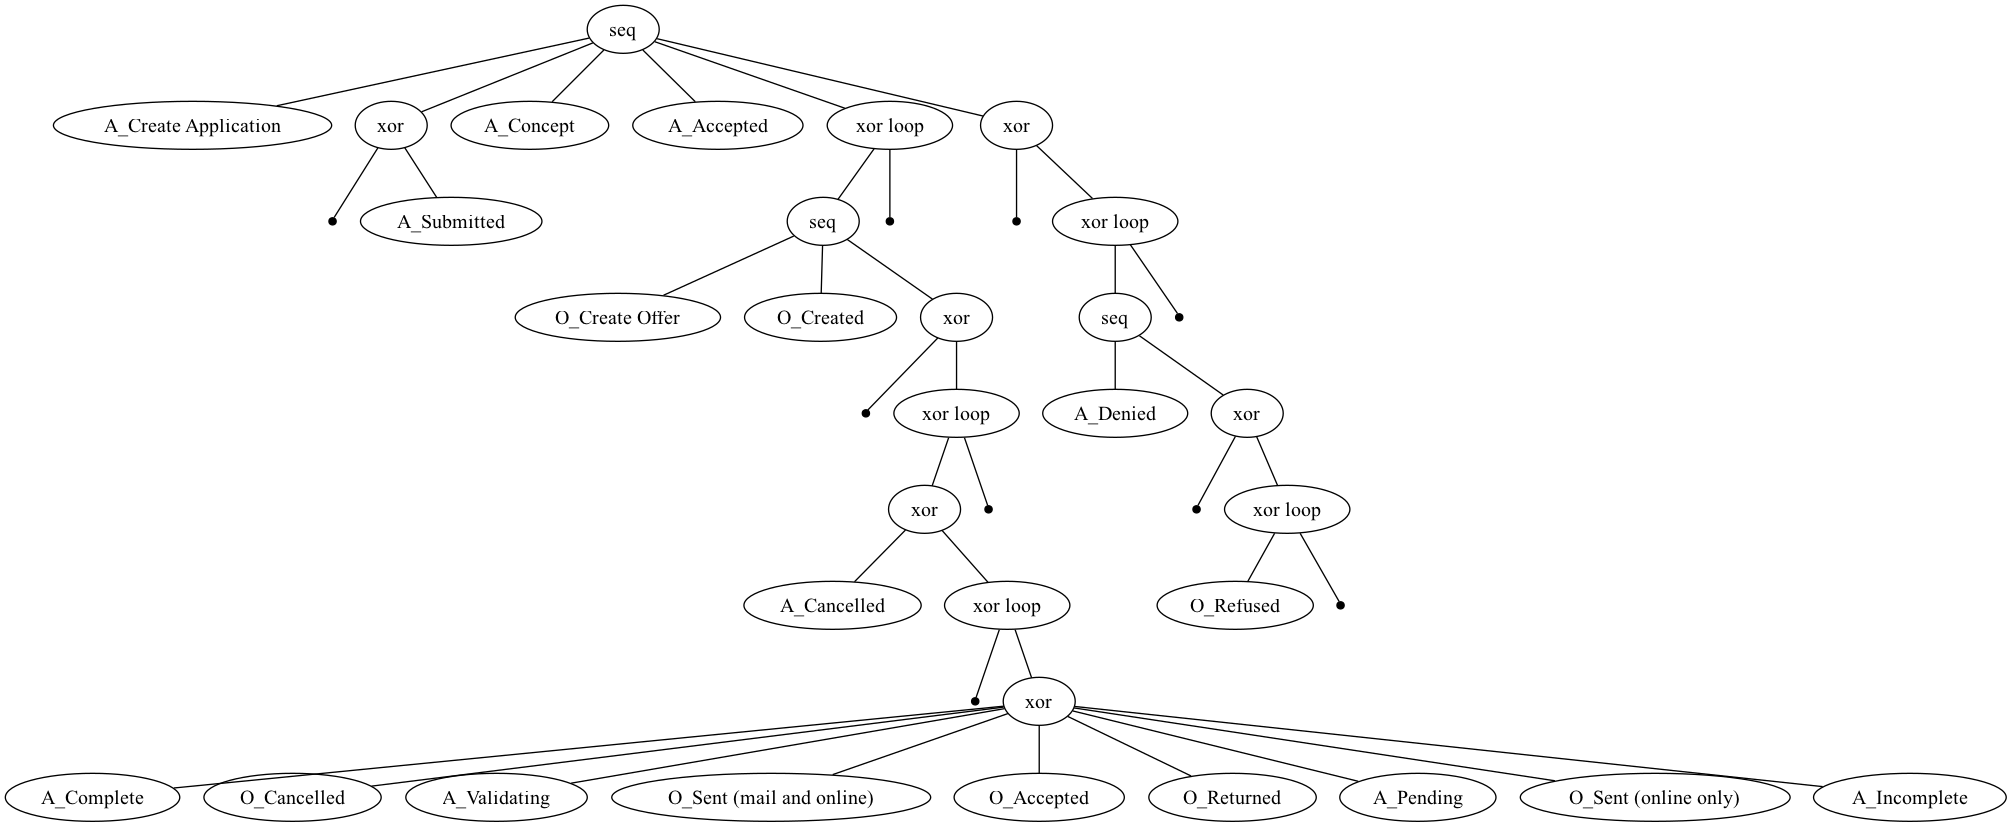

In [26]:
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(event_log_full)
tree = pm4py.discover_process_tree_inductive(event_log_full)
pm4py.view_process_tree(tree)

#### Heuristic miner

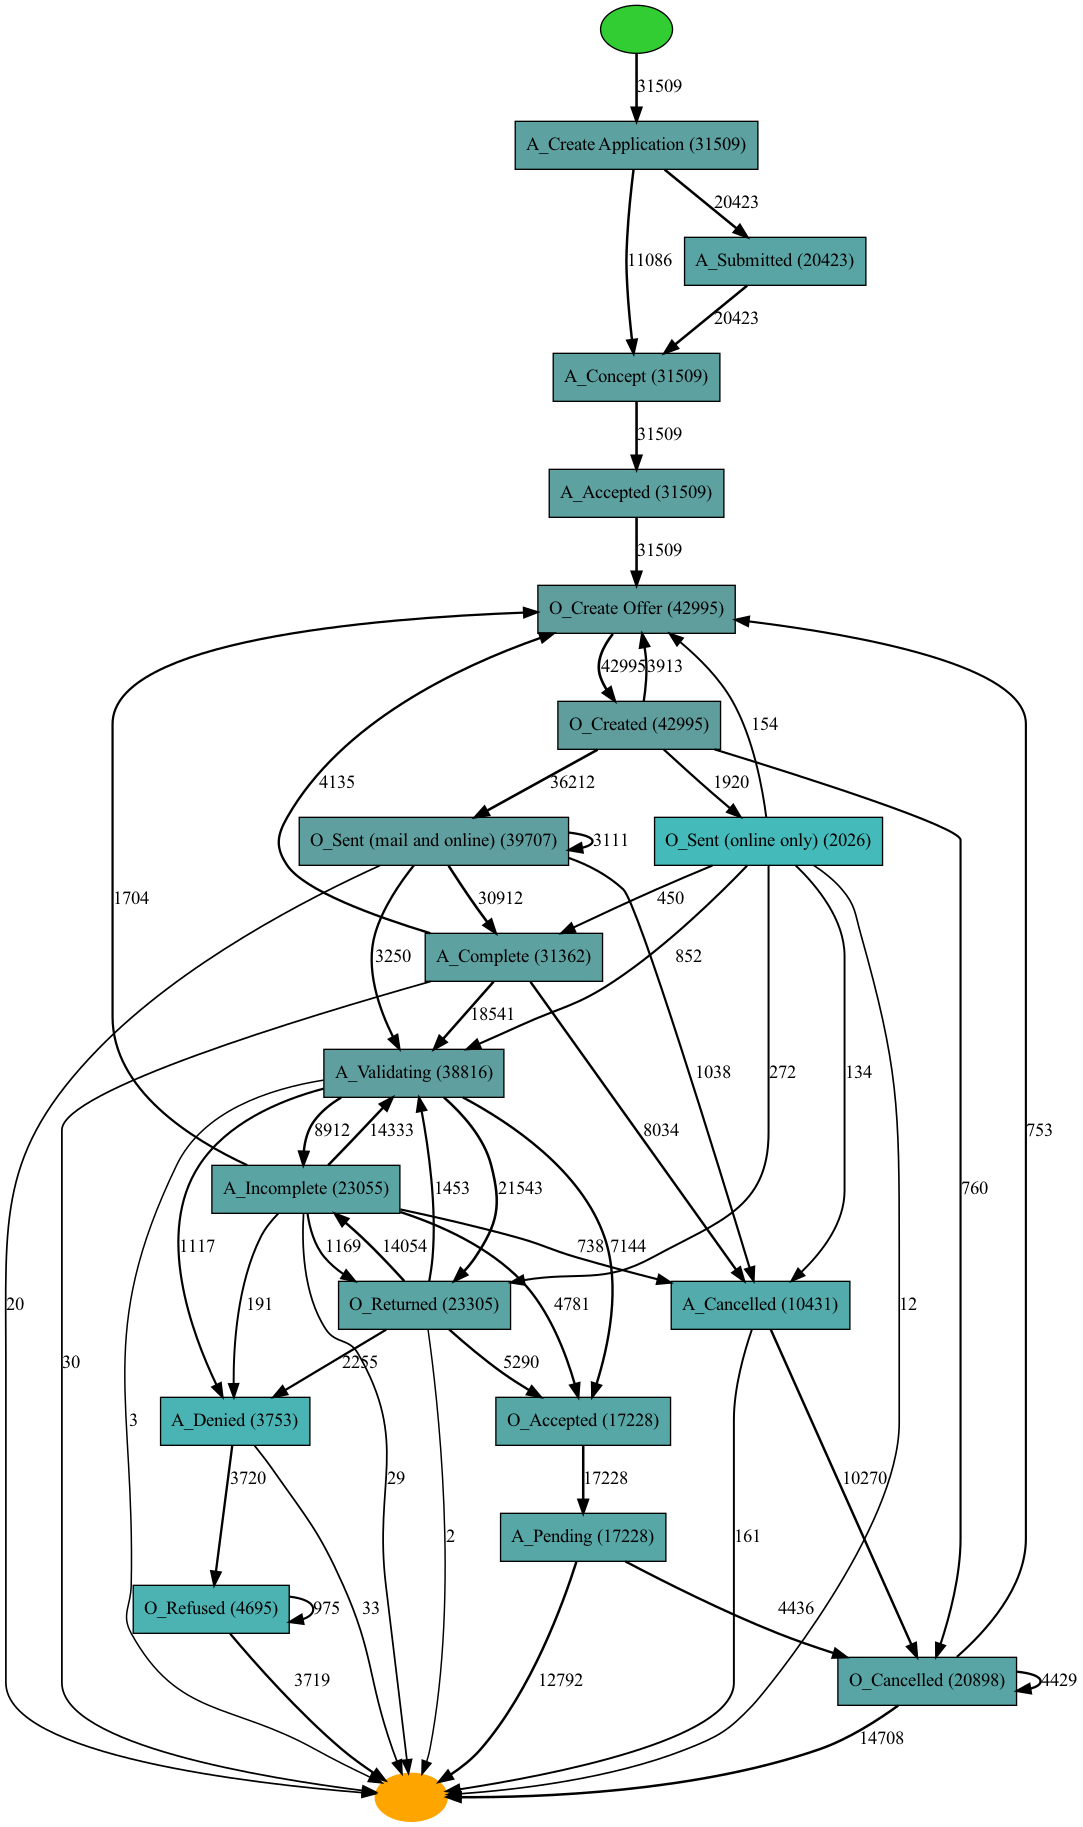

In [4]:
heu_net = pm4py.discover_heuristics_net(event_log_full, dependency_threshold=0.90)
pm4py.view_heuristics_net(heu_net)

In [5]:
net, initial_marking, final_marking = pm4py.convert_to_petri_net(heu_net)
pm4py.write_pnml(net, initial_marking, final_marking, "heuristics_net.pnml")

# Data Preporcessing: traces

Check type and correct

In [37]:
df.dtypes

Action                                object
EventID                               object
EventOrigin                           object
org:resource                          object
concept:name                          object
lifecycle:transition                  object
time:timestamp           datetime64[ns, UTC]
case:LoanGoal                         object
case:ApplicationType                  object
case:RequestedAmount                 float64
case:concept:name                     object
OfferedAmount                        float64
CreditScore                          float64
Selected                              object
MonthlyCost                          float64
Accepted                              object
NumberOfTerms                        float64
FirstWithdrawalAmount                float64
OfferID                               object
Year                                   int32
Month                                  int32
dtype: object

Date preprocessing

In [38]:
df['time:timestamp'] = pd.to_datetime(df['time:timestamp'], utc=True)
df['Year'] = df['time:timestamp'].dt.year
df['Month'] = df['time:timestamp'].dt.month

Printing the sample of the dataset

In [39]:
df.head(5)

,Action,EventID,EventOrigin,org:resource,concept:name,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:RequestedAmount,...,OfferedAmount,CreditScore,Selected,MonthlyCost,Accepted,NumberOfTerms,FirstWithdrawalAmount,OfferID,Year,Month
0,Created,Application_652823628,Application,User_1,A_Create Application,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,20000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016,1
1,statechange,ApplState_1582051990,Application,User_1,A_Submitted,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,20000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016,1
2,statechange,ApplState_642383566,Application,User_1,A_Concept,complete,2016-01-01 09:52:36.413000+00:00,Existing loan takeover,New credit,20000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016,1
3,statechange,ApplState_99568828,Application,User_52,A_Accepted,complete,2016-01-02 11:23:04.299000+00:00,Existing loan takeover,New credit,20000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016,1
4,Created,Offer_148581083,Offer,User_52,O_Create Offer,complete,2016-01-02 11:29:03.994000+00:00,Existing loan takeover,New credit,20000.0,...,20000.0,979.0,True,498.29,True,44.0,20000.0,NaN,2016,1


Traces dataset creation

In [51]:
case_attr_df = df.groupby('case:concept:name').agg({
    'case:LoanGoal': 'first',
    'case:RequestedAmount': 'first',
    'case:ApplicationType': 'first',
    'Month': 'first',
    'Year': 'first',
    'CreditScore': 'max'
}).reset_index()

Printing the sample of the dataset

In [54]:
case_attr_df.head(5)

,case:concept:name,case:LoanGoal,case:RequestedAmount,case:ApplicationType,Month,Year,CreditScore
0,Application_1000086665,"Other, see explanation",5000.0,New credit,8,2016,0.0
1,Application_1000158214,Home improvement,12500.0,New credit,6,2016,929.0
2,Application_1000311556,Car,45000.0,New credit,4,2016,0.0
3,Application_1000334415,"Other, see explanation",5000.0,New credit,9,2016,0.0
4,Application_1000339879,Existing loan takeover,37500.0,New credit,3,2016,798.0


# Visualaization of the traces

#### Number of traces by year and month

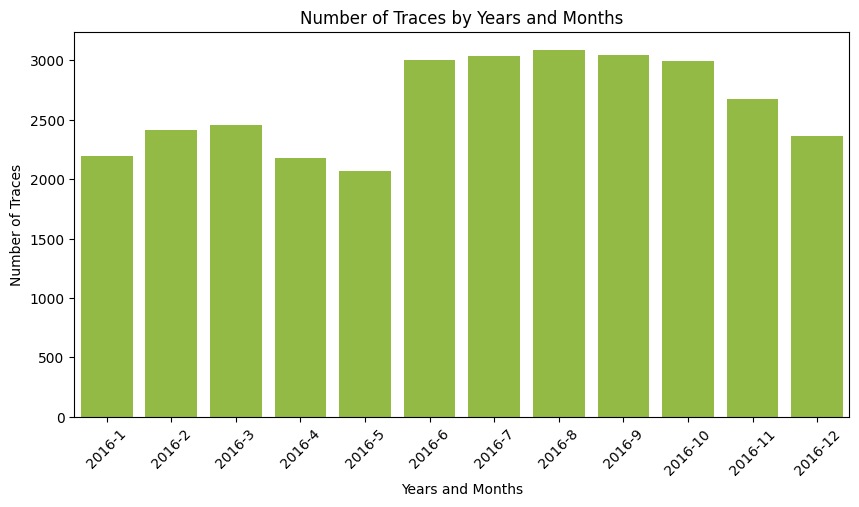

In [55]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()


temp = case_attr_df.groupby(['Year', 'Month']).size().reset_index(name='Count')


temp['YearMonth'] = temp['Year'].astype(str) + '-' + temp['Month'].astype(str)

grid = sns.barplot(x='YearMonth', y='Count', data=temp, color='yellowgreen')

ax.set_xlabel("Years and Months")  
ax.set_ylabel("Number of Traces")  
plt.title('Number of Traces by Years and Months')
plt.xticks(rotation=45) 
plt.show()


#### Distribution of Cases by Application Type

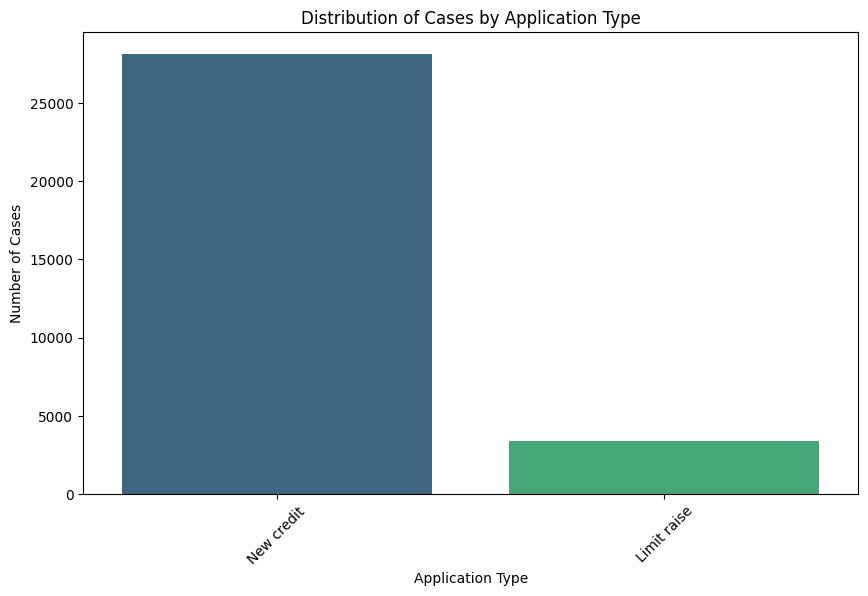

In [56]:
plt.figure(figsize=(10, 6))
sns.countplot(x='case:ApplicationType', data=case_attr_df, palette='viridis', order=case_attr_df['case:ApplicationType'].value_counts().index)
plt.xlabel('Application Type')
plt.ylabel('Number of Cases')
plt.title('Distribution of Cases by Application Type')
plt.xticks(rotation=45)
plt.show()

#### Distribution of Cases by Loan Goal

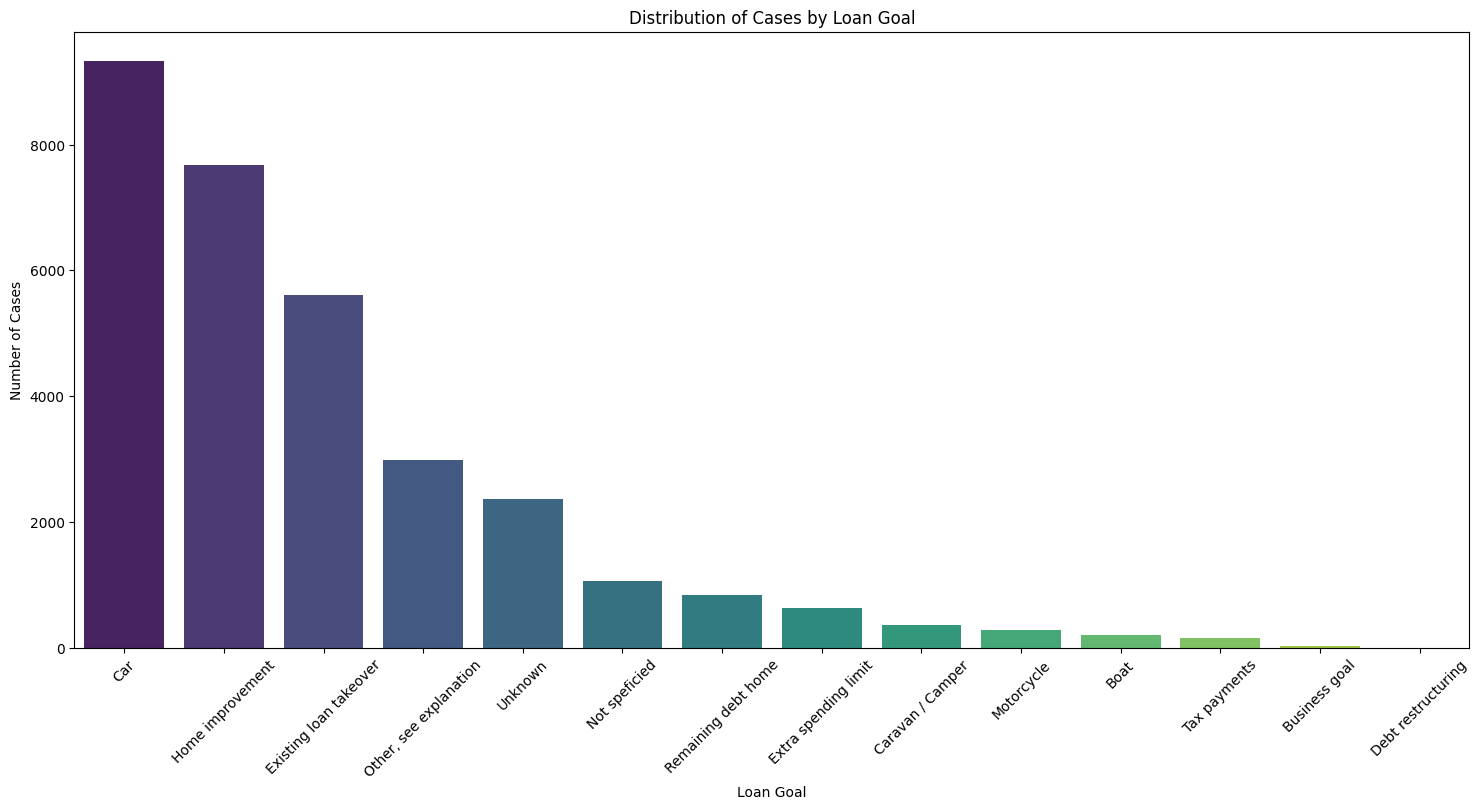

In [57]:
plt.figure(figsize=(18, 8))
sns.countplot(x='case:LoanGoal', data=case_attr_df, palette='viridis', order=case_attr_df['case:LoanGoal'].value_counts().index)
plt.xlabel('Loan Goal')
plt.ylabel('Number of Cases')
plt.title('Distribution of Cases by Loan Goal')
plt.xticks(rotation=45)
plt.show()

#### Visualization for Distribution of Cases by Requested Amount

From the exploration perspective we decided to analyse the Requested Amount attribute in three groups

In [58]:
df['case:RequestedAmount'].quantile([0.33,0.66])

0.33     8000.0
0.66    17500.0
Name: case:RequestedAmount, dtype: float64

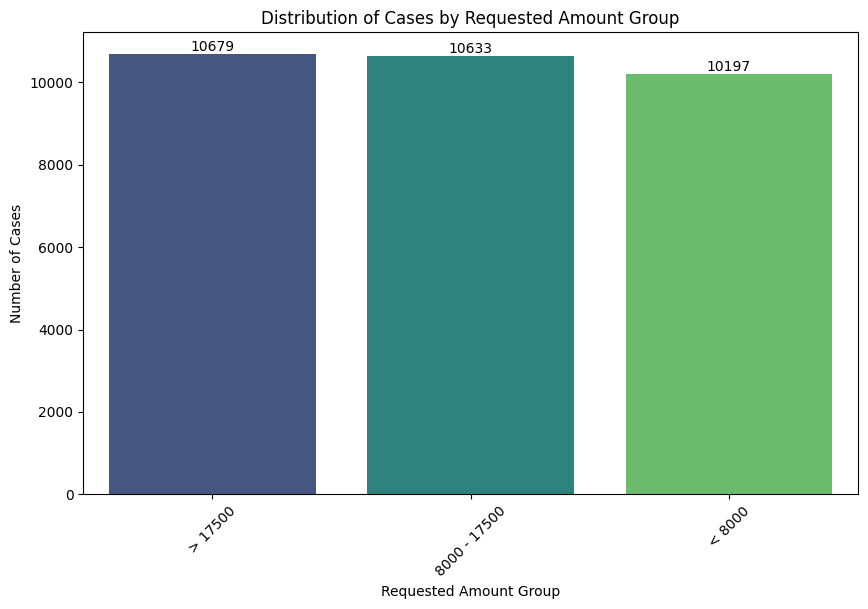

In [59]:
# Assuming case_attr_df is your DataFrame with the 'case:RequestedAmount' column
# Adjust the bin edges and labels as needed
bins = [0, 8000, 17500, float('inf')]
labels = ['< 8000', '8000 - 17500', '> 17500']

# Create a new column 'RequestedAmountGroup' based on binning
case_attr_df['RequestedAmountGroup'] = pd.cut(case_attr_df['case:RequestedAmount'], bins=bins, labels=labels, right=False)

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='RequestedAmountGroup', data=case_attr_df, palette='viridis',
                   order=case_attr_df['RequestedAmountGroup'].value_counts().index)
plt.xlabel('Requested Amount Group')
plt.ylabel('Number of Cases')
plt.title('Distribution of Cases by Requested Amount Group')
plt.xticks(rotation=45)

# Add values on the bars
for bar, count in zip(ax.patches, case_attr_df['RequestedAmountGroup'].value_counts()):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, count, ha='center', va='bottom')

plt.show()



#### Visualization for Credit score

From the exploration perspective we decided to analyse the Credit Score attribute in three groups as well

In [63]:
df['CreditScore'].quantile([0.70, 0.80])

0.7    794.0
0.8    888.0
Name: CreditScore, dtype: float64

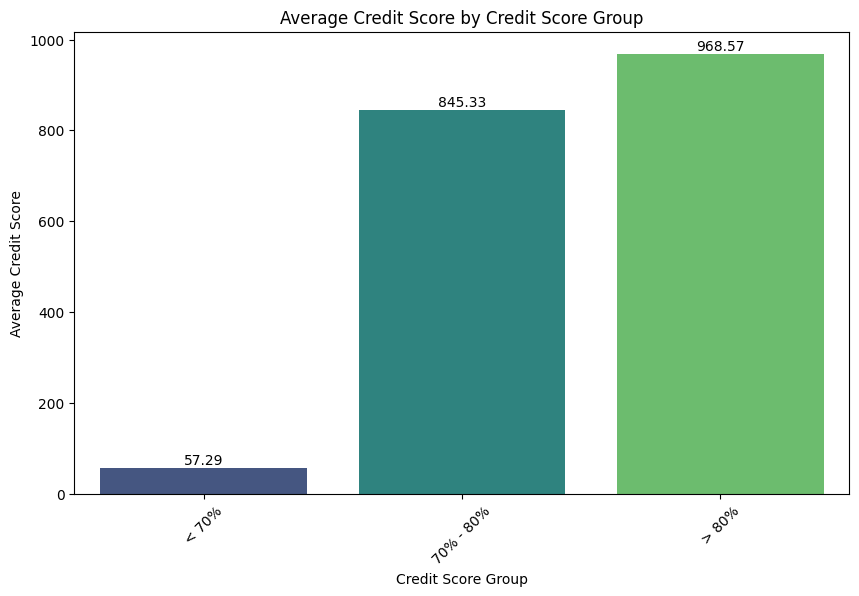

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df is your DataFrame with the 'CreditScore' column
# Adjust the bin edges and labels as needed
bins_credit = [0, df['CreditScore'].quantile(0.70), df['CreditScore'].quantile(0.80), float('inf')]
labels_credit = ['< 70%', '70% - 80%', '> 80%']

# Create a new column 'CreditScoreGroup' based on binning
df['CreditScoreGroup'] = pd.cut(df['CreditScore'], bins=bins_credit, labels=labels_credit, right=False)

# Calculate the average credit score for each group
average_credit_scores = df.groupby('CreditScoreGroup')['CreditScore'].mean().reset_index()

plt.figure(figsize=(10, 6))
ax_credit = sns.barplot(x='CreditScoreGroup', y='CreditScore', data=average_credit_scores, palette='viridis',
                        order=average_credit_scores.sort_values('CreditScoreGroup')['CreditScoreGroup'])
plt.xlabel('Credit Score Group')
plt.ylabel('Average Credit Score')
plt.title('Average Credit Score by Credit Score Group')
plt.xticks(rotation=45)

# Add values on the bars
for bar, avg_score in zip(ax_credit.patches, average_credit_scores['CreditScore']):
    height = bar.get_height()
    ax_credit.text(bar.get_x() + bar.get_width() / 2, height, f'{avg_score:.2f}', ha='center', va='bottom')

plt.show()
